In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [246]:
def load_train_test(train_file, test_file):
    """
    Loads in training and test data set
    
    Args:
    Training dataset filename
    Test dataset filename
    
    Returns:
    Training dataframe
    Test dataframe
    """
    
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    return (train_df, test_df)

In [247]:
# load train and test data
rossman_train_df, rossman_test_df = load_train_test('./data/train.csv', './data/test.csv')

In [249]:
rossman_train_df['Date'] = pd.to_datetime(rossman_train_df.Date)
rossman_test_df['Date'] = pd.to_datetime(rossman_test_df.Date)

## Exploratory Data Analysis

In [4]:
rossman_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 77.6+ MB


In [5]:
rossman_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.8+ MB


In [6]:
# take a look at the data
rossman_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
# Number of unique stores in training set
print 'Number of unique stores  %d ' %(len(rossman_train_df.Store.unique()))

Number of unique stores  1115 


In [8]:
# take a look at test data
rossman_test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [9]:
# Number of unique stores in test set
print 'Number of unique stores in test set %d ' %(len(rossman_test_df.Store.unique()))

Number of unique stores in test set 856 


In [10]:
# Describe 5 number summary for training and test dataset
rossman_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000,1017209.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647
std,321.908651,1.997391,3849.926175,464.411734,0.375539,0.485759,0.383056
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,3727.000000,405.000000,1.000000,0.000000,0.000000
50%,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000
75%,838.000000,6.000000,7856.000000,837.000000,1.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000


In [11]:
rossman_test_df.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


In [12]:
# Various features
rossman_train_df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [196]:
# Features captured in test examples
rossman_test_df.columns

Index([u'Id', u'Store', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday'],
      dtype='object')

In [13]:
# lets look into correlations
rossman_train_df.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,0.000641
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,0.085124
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,0.071568
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,0.086171
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,0.067483
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,1.000000


In [251]:
# Adding two new features Month and Quarter
rossman_train_df.loc[:, 'month'] = rossman_train_df.Date.dt.month
rossman_test_df.loc[:, 'month'] = rossman_test_df.Date.dt.month

In [257]:
# features to consider
features_to_consider = ['Store', 'DayOfWeek', 'Open', 'Promo', 'month']

## Subsampling

In [276]:
rossman_train_df_sample = rossman_train_df[rossman_train_df.Date > '2014-05-31']

## Loss Metric

In [277]:
from math import sqrt

def rmspe(y_true, y_pred):
    """
    Root Mean Square Percentage Error
    
    Args:
    y_true: true values for y
    y_pred: estimated values for y
    
    Returns: rmspe
    """
    
    n = len(y_true)
    e = []
    for i in range(n):
        if y_true[i] != 0:
            e.append((y_true[i] - y_pred[i]) / np.float(y_true[i]))
        else:
            e.append(0.0)
    
    e = np.array(e)
    e_squared = e ** 2
    return sqrt(np.sum(e_squared) / n)


## Modelling

In [278]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

In [279]:
train_data = rossman_train_df_sample[features_to_consider]
train_target = rossman_train_df_sample.Sales

In [280]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.3)

In [281]:
print 'Shape of training set %d and test set %d ' %(X_train.shape[0], X_test.shape[0])

Shape of training set 309309 and test set 132561 


## Linear Regression

In [282]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [283]:
# prediction on the training examples
train_est = lr.predict(X_train)

In [284]:
train_est = [pred if pred > 0 else 0.0 for pred in train_est]

In [285]:
# performance on the training set
print 'RMSPE on the trainig set %f ' %(rmspe(y_train.values, train_est))

RMSPE on the trainig set 0.455397 


In [286]:
# prediction on the test examples
test_est = lr.predict(X_test)

In [287]:
# performance on the test set
print 'RMSPE on the test set %f ' %(rmspe(y_test.values, test_est))

RMSPE on the test set 0.594582 


## Random Forest Regressor

In [288]:
from sklearn.ensemble import RandomForestRegressor

In [289]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [290]:
# prediction on the training examples
train_est_rf = rf.predict(X_train)

In [291]:
# performance on the training set
print 'RMSPE on the training set %f ' %(rmspe(y_train.values, train_est_rf))

RMSPE on the training set 0.105137 


In [292]:
# predictions on the test examples
test_est_rf = rf.predict(X_test)

In [293]:
# performance on the test set
print 'RMSPE on the test set %f ' %(rmspe(y_test.values, test_est_rf))

RMSPE on the test set 0.378824 


## Gradient Boosting Regression

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
gbr = GradientBoostingRegressor(n_estimators=50)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [41]:
train_est_gbr = gbr.predict(X_train)

In [42]:
# performance on the training set
print 'RMSPE on the training set %f ' %(rmspe(y_train.values, train_est_gbr))

RMSPE on the training set 0.462347 


In [43]:
# predictions on the test examples
test_est_gbr = gbr.predict(X_test)

In [44]:
# performance on the test examples
print 'RMSPE on the test set %f ' %(rmspe(y_test.values, test_est_gbr)) 

RMSPE on the test set 0.453013 


## Cross Validation

In [145]:
from sklearn.metrics import make_scorer

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [146]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit

rf = RandomForestRegressor(n_estimators=50, min_samples_split=5)
cv = ShuffleSplit(X_train.shape[0], n_iter=3, test_size=0.3,
    random_state=0)

test_scores = cross_val_score(rf, X_train.values, y_train.values, cv=cv, n_jobs=-1, scoring=rmspe_scorer)
test_scores

array([-0.13647944, -0.13291648, -0.1377935 ])

## Learning Curves

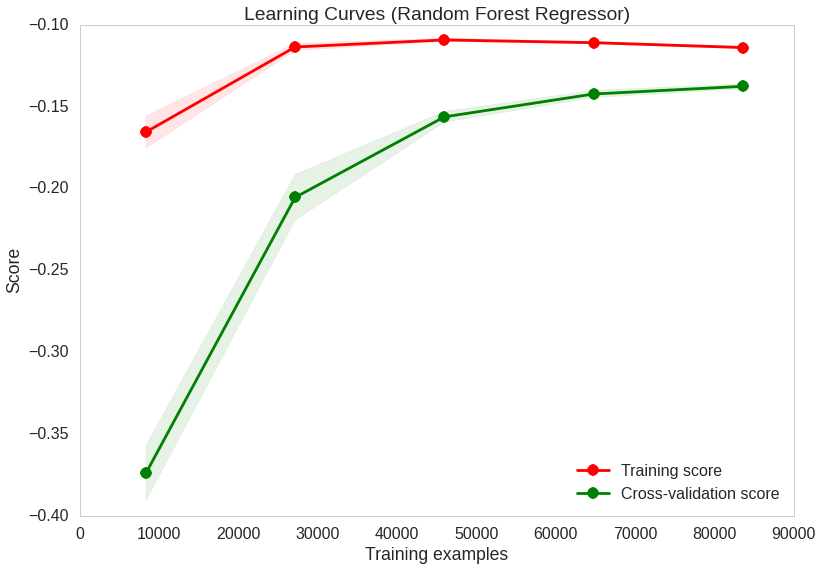

In [147]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=rmspe_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Random Forest Regressor)"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train, y_train.values, cv=cv, n_jobs=-1)
plt.show()

## Final Model preparation

In [215]:
# train linear regression on full training examples
lr.fit(train_data, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [189]:
# train random forest regressor on all training examples
rf.fit(train_data, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [190]:
test_df = rossman_test_df[features_to_consider]

In [191]:
# fill missing values in Open with 1
test_df.fillna(1, inplace=True)

In [192]:
linear_regression_preds = lr.predict(test_df)

In [193]:
rf_regression_preds = rf.predict(test_df)

## Create Submissions

In [194]:
def create_submission(ids, preds, filename):
    """
    Takes in ids and prediction for sales and submission filename
    
    Args:
    ids: Ids
    preds: Prediction for sales
    
    """
    
    submission_df = pd.DataFrame({'Id': ids, 'Sales': preds})
    submission_df.to_csv('./submissions/' + filename, index=False)
    

In [195]:
create_submission(rossman_test_df.Id.values, rf_regression_preds, 'rf_regression_preds_only_after_march_2015.csv')